In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

2.4.1


In [3]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [41]:
class CustomCallback_epoch(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # list of weight tensors
        curr_weight = self.model.get_weights()
        if weight_history:
          weight_change = [curr_weight[i] - weight_history[0][i] for i in range(len(curr_weight))]
          sum_delta = [tf.math.reduce_sum(tf.abs(t)).numpy() for t in weight_change]
          print('SUM OF ABS WEIGHT CHANGE FOR EACH LAYER RELATIVE TO INITIAL VALUES: ', sum_delta)
          weight_history.append(sum_delta) 
        else:
          weight_history.append(curr_weight)

In [42]:
# records only the mean change per layer, saving the whole weight matrix per batch takes too much memory
# first element reserved for the initial weights remove before use
class CustomCallback_batch(tf.keras.callbacks.Callback):
      def on_train_batch_begin(self, batch, logs=None):
        # list of weight tensors
        curr_weight = self.model.get_weights()
        if weight_history:
          weight_change = [curr_weight[i] - weight_history[0][i] for i in range(len(curr_weight))]
          # print('MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH')
          # print([tf.reduce_mean(t).numpy() for t in weight_change])
          weight_history.append([tf.math.reduce_sum(tf.abs(t)).numpy() for t in weight_change])
        else:
          weight_history.append(curr_weight)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5760 - accuracy: 0.8342 - val_loss: 0.1762 - val_accuracy: 0.9500
Epoch 2/100
SUM OF ABS WEIGHT CHANGE FOR EACH LAYER RELATIVE TO INITIAL VALUES:  [4960.6465, 7.952236, 95.84286, 0.6062987]
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1551 - accuracy: 0.9549 - val_loss: 

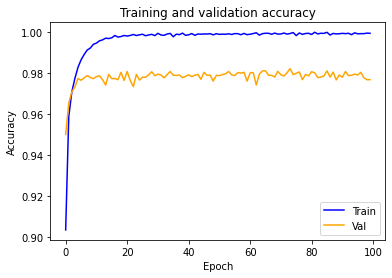

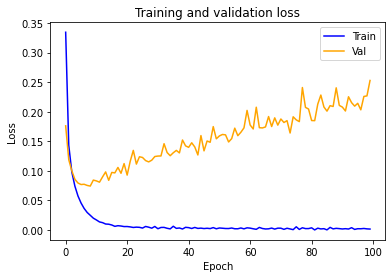

In [49]:
# this initializer uses 0.0025 as stddev, should trigger active training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.005, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_active = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

weight_history = []

print(model_active.summary())

model_active.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_active.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[CustomCallback_epoch()])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_active.predict(x_test), axis=1)))

active_weight_history = weight_history[1:]

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_39 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6345 - accuracy: 0.8116 - val_loss: 0.2003 - val_accuracy: 0.9402
Epoch 2/100
SUM OF ABS WEIGHT CHANGE FOR EACH LAYER RELATIVE TO INITIAL VALUES:  [4030.8472, 6.6896276, 79.97694, 0.8047328]
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1871 - accuracy: 0.9463 - val_loss:

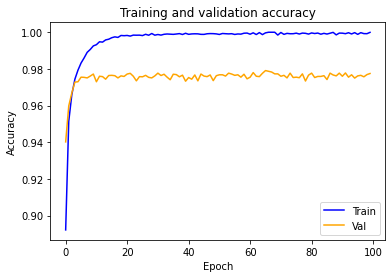

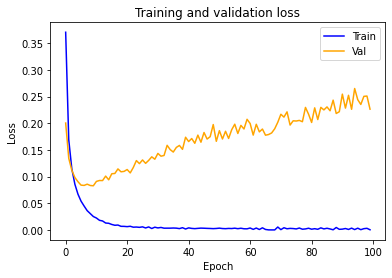

In [56]:
# this initializer uses 0.0025 as stddev, should trigger active training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0001, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_active = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

weight_history = []

print(model_active.summary())

model_active.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_active.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[CustomCallback_epoch()])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_active.predict(x_test), axis=1)))

active_weight_history = weight_history[1:]

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 57.5035 - accuracy: 0.5284 - val_loss: 8.6680 - val_accuracy: 0.8497
Epoch 2/100
SUM OF ABS WEIGHT CHANGE FOR EACH LAYER RELATIVE TO INITIAL VALUES:  [7718.0146, 12.076982, 150.56512, 0.7913406]
1875/1875 [==============================] - 4s 2ms/step - loss: 7.6597 - accuracy: 0.8572 - val_los

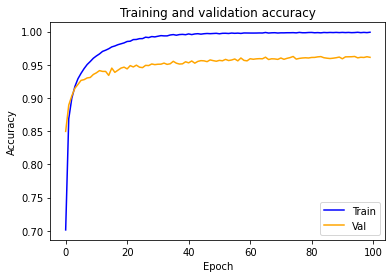

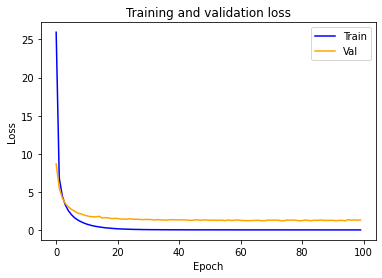

In [47]:
# this initializer uses sqrt(2) as stddev, much higher than default, should trigger lazy training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.414, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_lazy = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

weight_history = []

print(model_lazy.summary())

model_lazy.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_lazy.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[CustomCallback_epoch()])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

lazy_weight_history = weight_history[1:]

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 1318.7904 - accuracy: 0.3011 - val_loss: 246.2927 - val_accuracy: 0.7074
Epoch 2/100
SUM OF ABS WEIGHT CHANGE FOR EACH LAYER RELATIVE TO INITIAL VALUES:  [16652.523, 31.523624, 342.83347, 2.2866428]
1875/1875 [==============================] - 4s 2ms/step - loss: 218.5957 - accuracy: 0.7311 - v

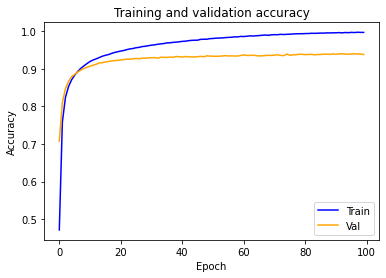

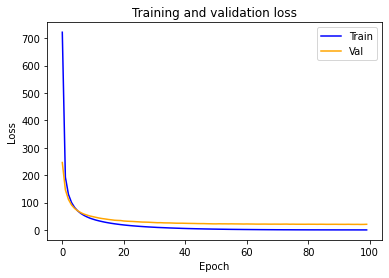

In [48]:
# this initializer uses sqrt(2) as stddev, much higher than default, should trigger lazy training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=5, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_lazy = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

weight_history = []

print(model_lazy.summary())

model_lazy.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_lazy.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[CustomCallback_epoch()])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

lazy_weight_history = weight_history[1:]

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4332 - accuracy: 0.8821 - val_loss: 0.1490 - val_accuracy: 0.9562
Epoch 2/100
SUM OF ABS WEIGHT CHANGE FOR EACH LAYER RELATIVE TO INITIAL VALUES:  [3174.9136, 5.2250824, 77.02713, 0.33927208]
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1374 - accuracy: 0.9592 - val_loss

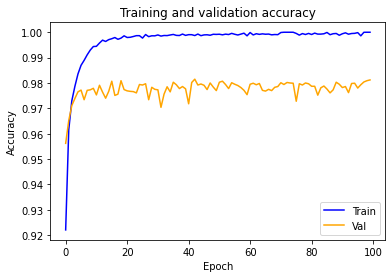

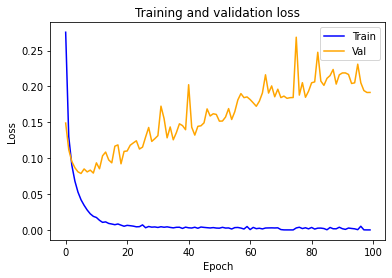

In [50]:
# this initializer uses sqrt(2) as stddev, much higher than default, should trigger lazy training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.005, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_lazy = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax')
])

weight_history = []

print(model_lazy.summary())

model_lazy.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_lazy.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[CustomCallback_epoch()])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

lazy_weight_history = weight_history[1:]

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 2.5989 - accuracy: 0.6781 - val_loss: 0.4166 - val_accuracy: 0.8982
Epoch 2/100
SUM OF ABS WEIGHT CHANGE FOR EACH LAYER RELATIVE TO INITIAL VALUES:  [5198.952, 6.650871, 77.63769, 0.32135946]
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3771 - accuracy: 0.9049 - val_loss: 

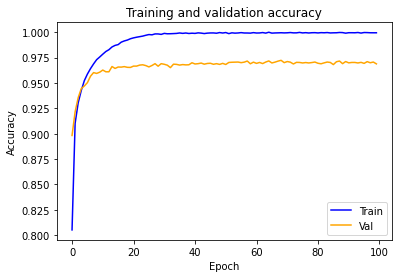

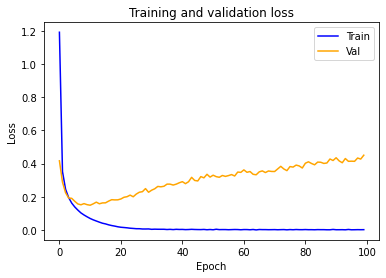

In [51]:
# this initializer uses sqrt(2) as stddev, much higher than default, should trigger lazy training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.414, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_lazy = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax')
])

weight_history = []

print(model_lazy.summary())

model_lazy.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_lazy.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[CustomCallback_epoch()])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

lazy_weight_history = weight_history[1:]

In [44]:
# initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0025, seed=20000)

# linear_low_var_model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
# ])

# weight_history = []

# linear_low_var_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# history = linear_low_var_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[CustomCallback_batch()])

# plot(history)
# print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

# linear_low_var_weight_history = weight_history

In [45]:
# initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.414, seed=20000)

# linear_high_var_model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
# ])

# weight_history = []

# linear_high_var_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# history = linear_high_var_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[CustomCallback_batch()])

# plot(history)
# print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

# linear_high_var_weight_history = weight_history

In [9]:
def incremental_weight_change(weight_history):
  return [[weight_history[i][j] - weight_history[i-1][j] for j in range(len(weight_history[i]))] for i in range(1,len(weight_history))]

In [10]:
def avg_weight_change(weight_history):
  return [[tf.reduce_mean(weight_history[i][j] - weight_history[i-1][j]).numpy() for j in range(len(weight_history[i]))] for i in range(1,len(weight_history))]

In [11]:
def avg_weight_change_over_time(weight_history):
  return np.mean(np.array(avg_weight_change(weight_history)))

In [34]:
def batch_avg_weight_change_over_time(weight_history):
  return (np.mean(np.array(weight_history),axis=0), np.mean(np.array(weight_history)))

In [ ]:
def batch_avg_weight_change_over_time(weight_history):
  return (np.mean(np.array(weight_history),axis=0), np.mean(np.array(weight_history)))

In [55]:
# epoch level
avg_weight_change_over_time(linear_low_var_weight_history)

-0.005216999

In [54]:
# epoch level
avg_weight_change_over_time(linear_high_var_weight_history)

-0.003043227

In [35]:
# epoch level
batch_avg_weight_change_over_time(active_weight_history)

(array([ 8.3410029e-08,  1.5459059e-06, -2.8259149e-06, -2.1263467e-07],
       dtype=float32), -3.5230588e-07)

In [36]:
# epoch level
batch_avg_weight_change_over_time(lazy_weight_history)

(array([-1.6503184e-06, -6.0093516e-06,  1.7687356e-07,  3.7212057e-08],
       dtype=float32), -1.8613964e-06)

In [31]:
# batch level
batch_avg_weight_change_over_time(active_weight_history)

(18749, 4)


-3.5230588e-07

In [26]:
# batch level
batch_avg_weight_change_over_time(lazy_weight_history)

-1.8613964e-06

In [ ]:
# batch level
avg_weight_change_over_time(linear_low_var_weight_history)

In [27]:
# batch level
avg_weight_change_over_time(linear_high_var_weight_history)